# Links
Github: https://github.com/katjadellalibera/KD-tree-implementation<br>
PyPI: https://pypi.org/project/Katjas-kd-tree/

# The content of the read-me file:
## KD-tree-implementation
An implementation of kd-search trees with functions to find the nearest neighbor, an operation that would take a long time using linear search on large datasets. That is where kd-search trees come in, since they can exclude a larger part of the dataset at once.<br>
This project was created as a final project for the course CS110/Computation: Solving Problems with algorithms.

## Installation guide
Open the Command center and paste the following<br>
```
pip install Katjas-kd-tree
```
#1(professionalism)
## How to run
After installing the package import it by typing<br>
```
import kd_tree as kd
```
You are now able to use the following functions<br>
```
kd.build_tree(dict)
# this will build a kd-tree from a given dictionary of format key:[values]
kd.distance(lsta,lstb)
# returns the distance between two points a and b with coordinates given by lsta and lstb
kd.find_approx_nearest(tree,value)
# returns the approximate nearest neighbor for a given value
kd.find_exact_nearest(tree,value)
# returns the exact nearest element of the tree to the value
```
## Example use case
To find the closest color in a dataset of named colors in the LAB (or CIELAB) color space. This color space works similar to RBG colors, but is design to let make colors that look similar to huymans be closer to each other in the color space. The first dimesnions is a spectrum from light to dark, the other two describe the green-red and blue-yellow value going from negative to positive value. More on LAB colors: https://en.wikipedia.org/wiki/CIELAB_color_space<br>
We cannot use our usual quick-search methods or binary search-trees, since the data has more than 1 dimension and cannot simply be ordered. Therefore, we can create a tree with 3 dimensions, where every new level is split along a new dimension, iterating through all of them as often as needed. This allows us to very quickly get an approximation of the nearest neighbor and with slightly more effort find the exact nearest neighbor quicker than with a linear search.<br>
```
# importing a dataset of paint colors and their position in the LAB colorspace
with open ("paintcolors.json") as json_file:
    paintcolors=json.load(json_file)
# creating a tree out of the paintcolors
painttree=kd.build_tree(paintcolors)
# finding the approximate and exact nearest color to [0,0,0]
print((kd.distance(kd.find_approx_nearest(painttree,[0,0,0]).value,[0,0,0]),
    kd.find_approx_nearest(painttree,[0,0,0]).name,
    kd.find_approx_nearest(painttree,[0,0,0]).value))
print(kd.find_exact_nearest(painttree,[0,0,0]))
```
This will return the approximate and exact nearest color to [0,0,0]<br>
(0.23327147726897515, 'UniversalBlack', [0.233007, 0.010686, -0.0030215])<br>
(0.22615200000001437, 'TwilightZone', [0.226152, 5.54817e-08, 5.84874e-08])<br>
<br>
The resulting kd-tree looks like this (nodes not above each other for clarity)<br>
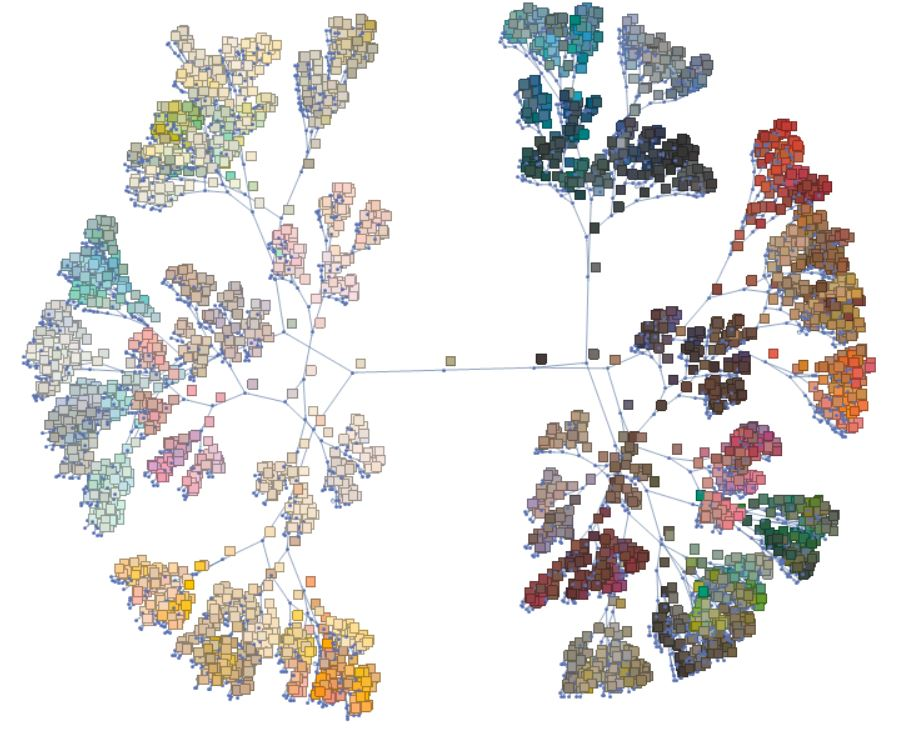
<br>
If you would like to run this code for yourself, please download the data from https://github.com/katjadellalibera/KD-tree-implementation/blob/master/paintcolors.json and the code from https://github.com/katjadellalibera/KD-tree-implementation/blob/master/example.py

## Background
**Time-Complexity:**<br>
A linear search runs with O(n) complexity, since it has to check every value. find_approx_nearest runs with $O(\log(n))$ complexity on average, because it just has to go down a binary tree with a depth of $\log_2(n)$. In the worst case we have a oddly shaped tree like one with only two nodes, where the worst-case runtime could be $O(n)$, because every node is visited. The find_exact_nearest function will exclude less of the tree at a time, but still run in $O(\log(n))$, just with a higher constant factor.<br>
**Space-Complexity:**<br>
Storing the data points as nodes rather than in a dictionary or array will still take $O(n)$ space complexity. There may be a slightly higher constant term k, accounting for the split-dimension d and pointers to the left an right child, but the total complexity is $O(n)$ 
#2(complexity) #3(optimalalgorithm)
## Dependencies
The implementation depends on a the pre-installed packages random, math and json as well as the numpy package.

# Implementation
#4(algorithms), #5(searchtrees), 

In [1]:
import numpy as np
import math
import random as random

class Node:

    def __init__(self,name,value,l_child,r_child,d):
        """
        definition of a node and its properties
        """
        self.name=name
        self.value=value
        self.l_child=l_child
        self.r_child=r_child
        self.d=d

    def __str__(self):
        """
        how to display a tree: every new level is indented
        example input:
        print(build_tree({"a":[1,1,1],"b":[3,5,2],"c":[3,5,7],"d":[5,1,2]}))
        example output:
        name: c, value: [3, 5, 7], d: 0
	       name: b, value: [3, 5, 2], d: 1
		         name: a, value: [1, 1, 1], d: 2
			              None
			              None
		         None
	       name: d, value: [5, 1, 2], d: 1
		         None
		         None
        """
        return "\t".join(str("name: {}, value: {}, d: {}  \n{}  \n{} ".format(
            self.name,self.value,self.d,self.l_child,self.r_child))
            .splitlines(True))


def build_tree(dictionary,d=0):
    """
    Function to build a tree from a dictionary of names and values
    """
    # make sure the dictionary is not empty
    if len(dictionary)==0:
        return None
    # Base case: for a single node, we return the Node that is formed 
    # when both children are empty
    if len(dictionary)==1:
        return Node(list(dictionary.keys())[0],
            list(dictionary.values())[0],None,None,d)
    # sort the dictionary indexes by the dimension specified by input d
    sortedindexes=sorted(list(dictionary.keys()),
        key=(lambda x: dictionary[x][d]))
    # decide the pivot point, the points below and above it                                                 
    pivot=sortedindexes[len(sortedindexes)//2]
    lower={i:dictionary[i] for i in sortedindexes[:len(sortedindexes)//2]}
    upper={i:dictionary[i] for i in sortedindexes[len(sortedindexes)//2+1:]}
    # the pivot is the parent node of the tree
    # the children are the trees formed from recursively calling build_tree,
    # updating d every iteration
    # the dimension is the dimension from the input
    return Node(pivot,dictionary[pivot],
        build_tree(lower,(d+1)%len(list(dictionary.values())[0])),
        build_tree(upper,(d+1)%len(list(dictionary.values())[0])),d)

def find_approx_nearest(tree,value):
    """
    function to very quickly find an approximation for the nearest neighbor
    it may not be exact if the point is close to one of the pivot points,
    because the nearest neighbor may be excluded prematurely
    """
    # base case: if we reach a node with no children, we return it
    if tree.l_child==None and tree.r_child==None:
        return tree
    # if the value is below the tree parent in the sorting dimension,
    # we return either the tree or the approximate nearest from the left child
    elif tree.value[tree.d]>=value[tree.d]:
        if tree.l_child!=None:
            return find_approx_nearest(tree.l_child,value)
        else:
            return tree
    # if the value is above, we return the tree or approximation from the right 
    # child
    else:
        if tree.r_child!=None:
            return find_approx_nearest(tree.r_child,value)
        else:
            return tree

def distance(lsta, lstb):
    """
    Finds the distance between two coordinates in k dimensions with coordinates
    described as lists
    """
    if len(lsta)!=len(lstb):
        return "Error: wrong dimensions"
    return math.sqrt(sum([(lsta[i]-lstb[i])**2 for i in range(len(lsta))]))



def find_exact_nearest(tree,value):
    """
    finds the exact nearest neighbor by searching any node that is approximately
    as close as the nearest neighbor
    """
    # define variables within the function that will be gradually updated
    closest=find_approx_nearest(tree,value)
    approx=closest.value
    dist=distance(approx,value)
    
    #defne a helper function that loops through the tree
    def find_exact_nearest_helper(tree,value):
        """
        helper function to find the exact nearest neighbor
        """
        # tell the function that the variables dist and closest are not local
        # and therefore not reset every iteration
        nonlocal dist
        nonlocal closest
        # if the distance to the current node is shorter than to the approximate
        # nearest, updated the variables
        if dist>distance(tree.value,value):
            closest=Node(tree.name,tree.value,None,None,None)
            dist=distance(tree.value,value)
        # if the current distance could reach beyond the current node in the 
        # split dimension d, we need to check on both sides of the tree
        if dist>abs(tree.value[tree.d]-value[tree.d]):
            if tree.l_child!=None:
                find_exact_nearest_helper(tree.l_child,value)
            if tree.r_child!=None:
                find_exact_nearest_helper(tree.r_child,value)
        # if the current distance does not reach beyond the current node in the
        # split dimension d, we only need to check on either the left or right
        # side of the tree, depending on the value
        if dist<abs(tree.value[tree.d]-value[tree.d]):
            if tree.value[tree.d]>=value[tree.d]:
                if tree.l_child!=None:
                    find_exact_nearest_helper(tree.l_child,value)
            else:
                if tree.r_child!=None:
                    find_exact_nearest_helper(tree.r_child,value)
                    
    # call on the helper function in the main function to change the variables
    find_exact_nearest_helper(tree,value)
    # return the updated variables
    return (dist,closest.name,closest.value)


# Content of setup.py file (with file path edited for desktop)
#6(novelapplication)

In [2]:
import numpy as np
import json
import kd_tree as kd

# generate 1000 random data points and building a tree from them
exampledictionary=dict(enumerate(np.random.rand(1000,4).tolist()))
exampletree=kd.build_tree(exampledictionary)
# finding the approximate nearest neighbor and its distance to a value
print(kd.distance(kd.find_approx_nearest(exampletree,[0.2,0.7,0.9,0.5]).value,
            [0.2,0.7,0.9,0.5]),
    kd.find_approx_nearest(exampletree,[0.2,0.7,0.9,0.5]).value)
# finding the exact nearest neighbor
print(kd.find_exact_nearest(exampletree,[0.2,0.7,0.9,0.5]))
# compare with a linear search
def linear_search(dict,value):
    lowestdist=float("inf")
    lowest={}
    for key, item in dict.items():
        if kd.distance(item,value)<lowestdist:
            lowestdist=kd.distance(item,value)
            lowest={key:item}
    return (lowestdist,lowest)
print(linear_search(exampledictionary,[0.2,0.7,0.9,0.5]))

# importing a dataset of paint colors and their position in the LAB colorspace
with open ("C:\\Users\\rbc15\\Desktop\\Minerva\\second year\\first semester"
    "\\CS110\\Assignments\\KD-tree-implementation\\paintcolors.json") as json_file:
    paintcolors=json.load(json_file)
# creating a tree out of the paintcolors
painttree=kd.build_tree(paintcolors)
# finding the approximate and exact nearest color to [0,0,0]
print((kd.distance(kd.find_approx_nearest(painttree,[0,0,0]).value,[0,0,0]),
    kd.find_approx_nearest(painttree,[0,0,0]).name,
    kd.find_approx_nearest(painttree,[0,0,0]).value))
print(kd.find_exact_nearest(painttree,[0,0,0]))


0.2203529145985767 [0.16178652650261227, 0.5882990107017819, 0.9901572855738633, 0.6627565367753453]
(0.07683096638875365, 162, [0.1329039379644562, 0.7049195357644147, 0.8726062415683767, 0.4749700974351724])
(0.07683096638875365, {162: [0.1329039379644562, 0.7049195357644147, 0.8726062415683767, 0.4749700974351724]})
(0.23327147726897515, 'UniversalBlack', [0.233007, 0.010686, -0.0030215])
(0.22615200000001437, 'TwilightZone', [0.226152, 5.54817e-08, 5.84874e-08])


# Visualization of the color tree
To visualize the color tree, I used an implementation of the same tree in Mathematica and used their graphic function to make a visualization, we can easily see the split between light and dark and after that between the different colors.#7(professionalism)
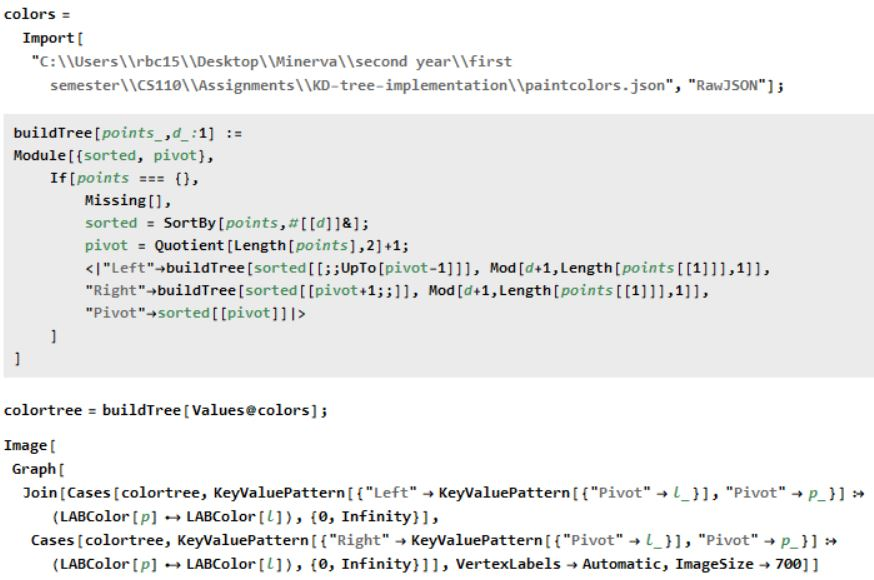
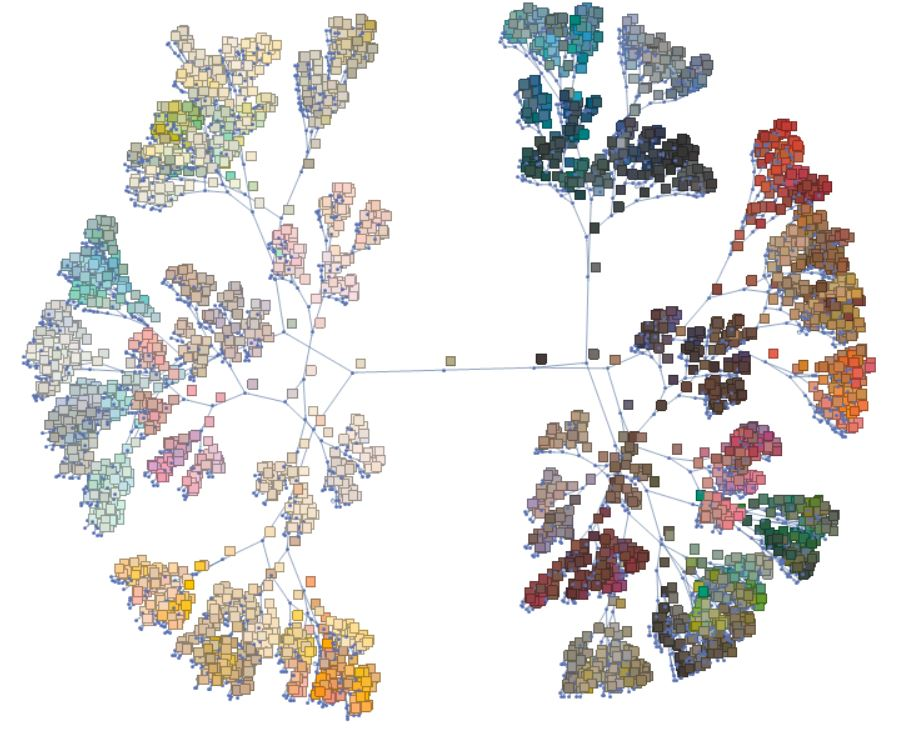

# HC-Tags:
#1: Professionalism- For this assignment, I mastered a new format of coding for me, using an editor and py files rather than jupyter notebooks. I learned a lot I can use in the future and successfully followed readme guidelines, how to present code in them and uploaded my package to PyPI.<br>
#2: Complexity- I use Big-O notation to analyse the time and space complexity of the solution and how it is an improvement to the only other option we had before, a linear search. I briefly explain WHY the time-complexity is logarithmic and space complexity order $O(n)$ and stays so on average in both cases.<br>
#3: optimalalgorithm- By making my algorithm efficiently and by explaining the complexity, I found a more efficient way of finding the nearest fit to a value in a mutli-dimesnional dataset.<br>
#4: algorithms- I successfully devised algorithms that build a kd-tree, find the nearest and approximate nearest.<br>
#5: searchtrees- I was inspired to this implementation by the binary search tree unit of the course and my class of nodes is built on the implementation for one-dimensional search trees. I explain why a search tree is the best option for searching a mutli-dimensional space and how this solution improves upon the linear search otherwise available to us.<br>
#6: Novelapplication- After finding a relevant problem about colors, I implemented a quick solution, documented it well and justified why it is a great solution to the problem. I even added some more visualizations about the color-space<br>
#7: professionalism- I went the extra mile to visualize my result into a beautiful tree structure.
